In [37]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import warnings
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

In [38]:
data = pd.read_csv('dataset_57_hypothyroid.csv')
data.replace('?', np.nan, inplace=True)
data.dropna(subset=['Class'], axis=0, inplace=True)

In [39]:
data.shape

(3772, 30)

In [40]:
data.head()

age sex on_thyroxine query_on_thyroxine on_antithyroid_medication sick  \
0  41   F            f                  f                         f    f   
1  23   F            f                  f                         f    f   
2  46   M            f                  f                         f    f   
3  70   F            t                  f                         f    f   
4  70   F            f                  f                         f    f   

  pregnant thyroid_surgery I131_treatment query_hypothyroid  ... TT4_measured  \
0        f               f              f                 f  ...            t   
1        f               f              f                 f  ...            t   
2        f               f              f                 f  ...            t   
3        f               f              f                 f  ...            t   
4        f               f              f                 f  ...            t   

   TT4 T4U_measured   T4U FTI_measured  FTI TBG_measured TBG referral_source  \
0  125            t  1.14            t  109            f NaN            SVHC   
1  102            f   NaN            f  NaN            f NaN           other   
2  109            t  0.91            t  120            f NaN           other   
3  175            f   NaN            f  NaN            f NaN           other   
4   61            t  0.87            t   70            f NaN             SVI   

      Class  
0  negative  
1  negative  
2  negative  
3  negative  
4  negative  

[5 rows x 30 columns]

In [41]:
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='ignore')

## Выводы по EDA

TODO:
- Stratify data by target
- Use precission and recall as main metric 
- Use median imputer for numerical features
- Most frequent imputer for categorical features
- One-hot encoder for categorical features
- Drop duplicates
- Drop empty columns
- hypopituitary column is always False
- Drop secondary_hypothyroid class rows

In [42]:
bool_cols = [col for col in data.columns if data[col].nunique() == 2 and data[col][0] in ['t', 'f']]
for col in bool_cols:
    data[col] = data[col] == 't'

In [43]:
data.head()

age sex  on_thyroxine  query_on_thyroxine  on_antithyroid_medication  \
0  41.0   F         False               False                      False   
1  23.0   F         False               False                      False   
2  46.0   M         False               False                      False   
3  70.0   F          True               False                      False   
4  70.0   F         False               False                      False   

    sick  pregnant  thyroid_surgery  I131_treatment  query_hypothyroid  ...  \
0  False     False            False           False              False  ...   
1  False     False            False           False              False  ...   
2  False     False            False           False              False  ...   
3  False     False            False           False              False  ...   
4  False     False            False           False              False  ...   

   TT4_measured    TT4  T4U_measured   T4U  FTI_measured    FTI  TBG_measured  \
0          True  125.0          True  1.14          True  109.0             f   
1          True  102.0         False   NaN         False    NaN             f   
2          True  109.0          True  0.91          True  120.0             f   
3          True  175.0         False   NaN         False    NaN             f   
4          True   61.0          True  0.87          True   70.0             f   

   TBG  referral_source     Class  
0  NaN             SVHC  negative  
1  NaN            other  negative  
2  NaN            other  negative  
3  NaN            other  negative  
4  NaN              SVI  negative  

[5 rows x 30 columns]

In [44]:
data.drop(['TBG_measured', 'TBG', 'hypopituitary'], axis=1, inplace=True)

In [45]:
data.drop_duplicates(inplace=True)
# y = data['Class']
# data.drop('Class', axis = 1, inplace=True)

In [46]:
TARGET = 'Class'
SEED = 13

In [47]:
data.dtypes

age                          float64
sex                           object
on_thyroxine                    bool
query_on_thyroxine              bool
on_antithyroid_medication       bool
sick                            bool
pregnant                        bool
thyroid_surgery                 bool
I131_treatment                  bool
query_hypothyroid               bool
query_hyperthyroid              bool
lithium                         bool
goitre                          bool
tumor                           bool
psych                           bool
TSH_measured                    bool
TSH                          float64
T3_measured                     bool
T3                           float64
TT4_measured                    bool
TT4                          float64
T4U_measured                    bool
T4U                          float64
FTI_measured                    bool
FTI                          float64
referral_source               object
Class                         object
d

In [48]:
cat_cols = list(set([col for col in data.columns if data[col].dtype =='object']) - {TARGET})
num_cols = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]
bool_cols = [col for col in data.columns if data[col].dtype == 'bool']

In [49]:
data = data[data[TARGET] != 'secondary_hypothyroid']

In [50]:
X = data.drop(TARGET, axis=1)
y= data[TARGET]

In [51]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [16]:
report = ProfileReport(data)
report.to_notebook_iframe()

In [52]:
X_train, X_test, y_train, y_test = train_test_split(data, y, stratify=y, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train, random_state=SEED)

In [53]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

## Pipeline для предобработки данных

### Состоит из:
<ul>
    <li>Заполнение пропусков в числовых и категориальных значений</li>
    <li>Кодирование категориальных признаков</li>
    <li>Далее Pipeline соберется в другой, содержащий модель</li>
</ul>

In [54]:
num_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
    
])
cat_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

bool_trans = Pipeline(steps=[
    ('encoder', OrdinalEncoder())
])


preprocessor = ColumnTransformer(
transformers =[
    ('num', num_trans, num_cols),
    ('cat', cat_trans, cat_cols),
    ('bool', bool_trans, bool_cols)
], remainder='drop')

In [55]:
import numpy as np
from sklearn.pipeline import Pipeline
import eli5
import seaborn as sns
import matplotlib.pyplot as plt
import re


def replace_feature_name(name, raw_col_name):
    index = get_raw_feature_index(name)
    if index is None:
        return name
    else:
        return name.replace('x{}_'.format(index), '{}_'.format(raw_col_name[index]))


def get_raw_feature_index(name):
    try:
        return int(re.search(r'x\d+_', name).group().replace('x', '').replace('_', ''))
    except:
        return None


def replace_poly_feature_name(name, raw_col_name):
    indices = get_raw_poly_feature_indices(name)
    if indices is None:
        return name
    else:
        for i in indices:
            name = name.replace('x{}'.format(i), '{}'.format(raw_col_name[i]))
        return name


def get_raw_poly_feature_indices(name):
    try:
        return [int(ind.replace('x', '')) for ind in re.findall(r'x\d+', name)]
    except:
        return None



def get_column_names_from_column_transformer(column_transformer, columns, remainder='passthrough'):
    col_name = []
    if remainder == 'drop':
        transformers = column_transformer.transformers_[:-1]
    elif remainder == 'passthrough':
        transformers = column_transformer.transformers_
    else:
        raise AttributeError('not valid value for parameter remainder')

    for transformer_in_columns in transformers:
        step_name = transformer_in_columns[0]
        raw_col_name = transformer_in_columns[2]

        if isinstance(transformer_in_columns[1], Pipeline):
            transformers = [trans[1] for trans in transformer_in_columns[1].steps if
            hasattr(trans[1], 'get_feature_names')]
            if len(transformers) > 0:
                transformer = transformers[-1]
            else:
                transformer = None
        else:
            transformer = transformer_in_columns[1]

        try:
            names = transformer.get_feature_names()
            # if no 'get_feature_names' function, use raw column name
        except AttributeError:
            names = raw_col_name
        if isinstance(names, (np.ndarray, list)):
            if type(transformer).__name__ == 'OneHotEncoder':
                names = [replace_feature_name(name, raw_col_name) for name in names]
            elif type(transformer).__name__ == 'PolynomialFeatures':
                names = [replace_poly_feature_name(name, raw_col_name) for name in names]
            elif step_name == 'remainder':
                names = [columns[int(name)] for name in names]
                names = ['{}_{}'.format(step_name, name) for name in names]
            col_name += names
        elif isinstance(names, str):
            col_name.append('{}_{}'.format(step_name, names))
    return col_name


def get_feature_names(pipeline, init_columns, remainder='passthrough'):
    columns = []
    for name, step in pipeline.named_steps.items():
        if type(step).__name__ == 'ColumnTransformer':
            columns += get_column_names_from_column_transformer(step, init_columns, remainder=remainder)
        elif hasattr(step, 'get_feature_names'):
            columns += step.get_feature_names()

    return columns


## Baseline

In [56]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import recall_score, precision_score, log_loss, f1_score


# логистическая регрессия без регуляризации
model = LogisticRegression(penalty='none')
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

logistic_pipeline.fit(X_train, y_train)

preds = logistic_pipeline.predict(X_valid)
prob_preds=logistic_pipeline.predict_proba(X_valid)

cols = get_feature_names(logistic_pipeline, X.columns, remainder='drop')

logloss  0.23609170828264983
Полнота  0.8317757009345795
Точность  0.9121572020345027
F1  0.8650540404292212


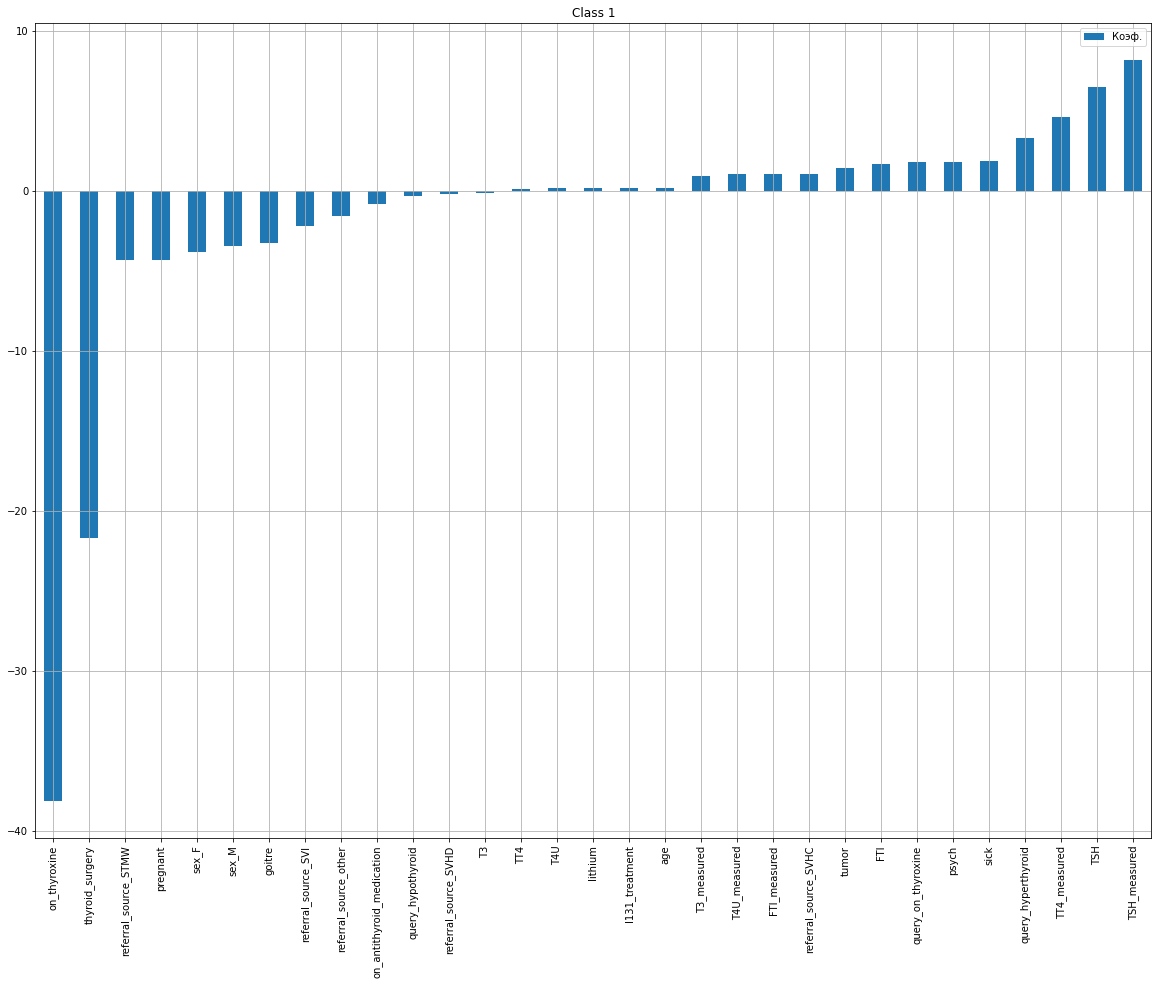

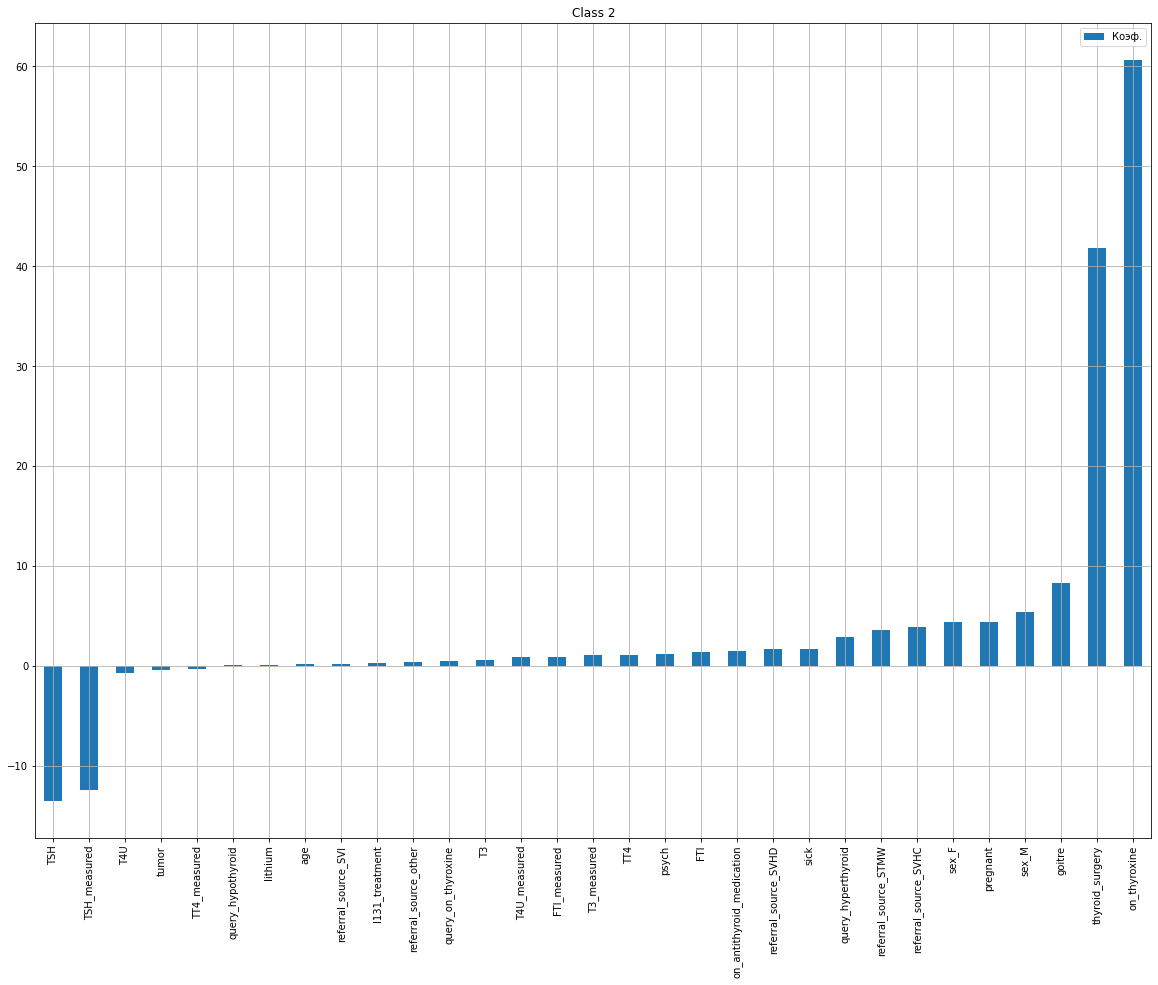

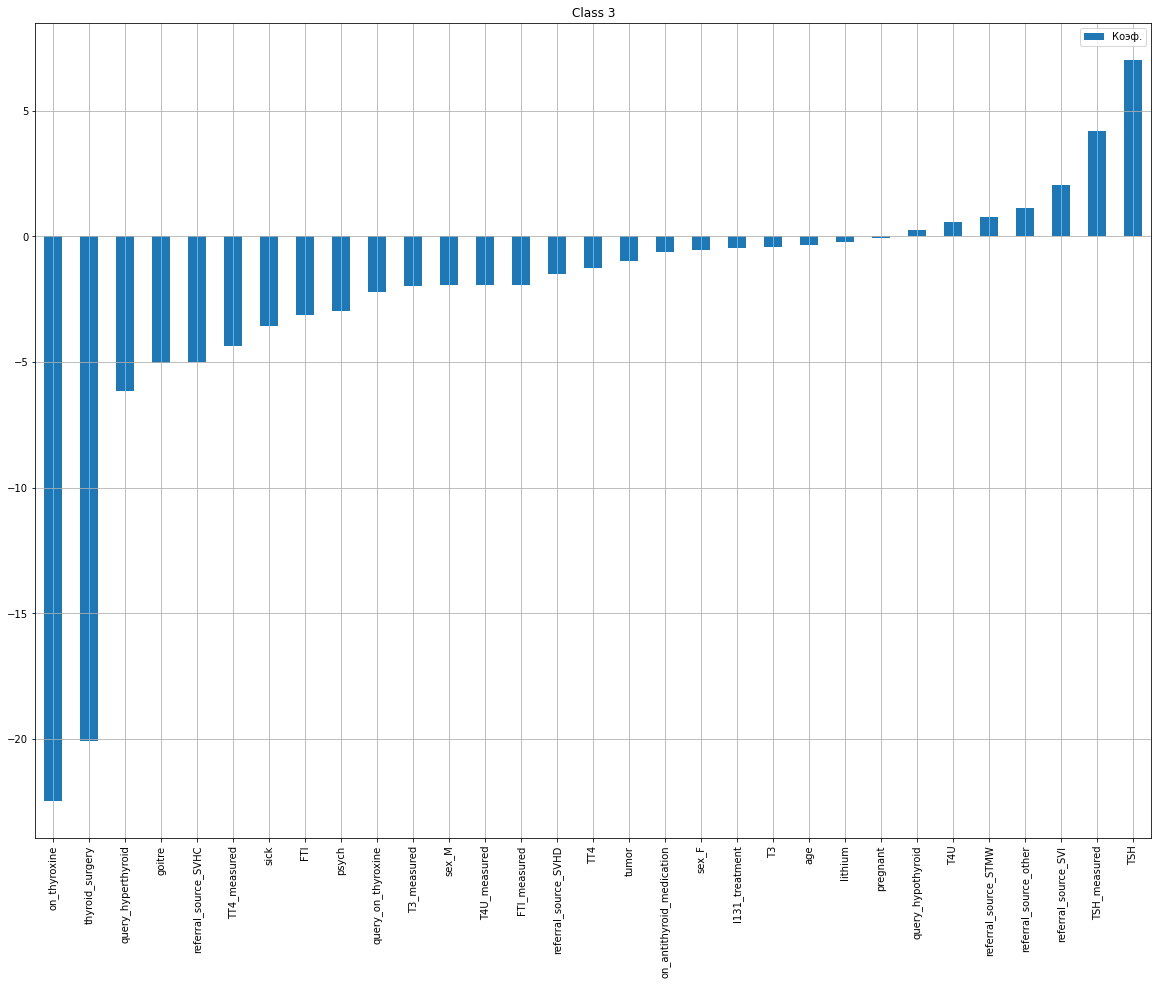

In [57]:
print('logloss ', log_loss(y_valid, prob_preds))
print('Полнота ', recall_score(y_valid, preds, average='macro'))
print('Точность ', precision_score(y_valid, preds, average='macro'))
print('F1 ', f1_score(y_valid, preds, average='macro'))
for i in range(3):
    coef = pd.DataFrame(logistic_pipeline[1].coef_[i], cols).sort_values(by=0)
    coef.columns = ['Коэф.']
    coef.plot.bar(grid=True, title='Сlass ' + str(i + 1), figsize=(20, 15))

## Логистическая регрессия с разными видами регуляризации


### L1

logloss 0.15933593911776325
Полнота  0.8317757009345795
Точность  0.9121572020345027
F1  0.8650540404292212


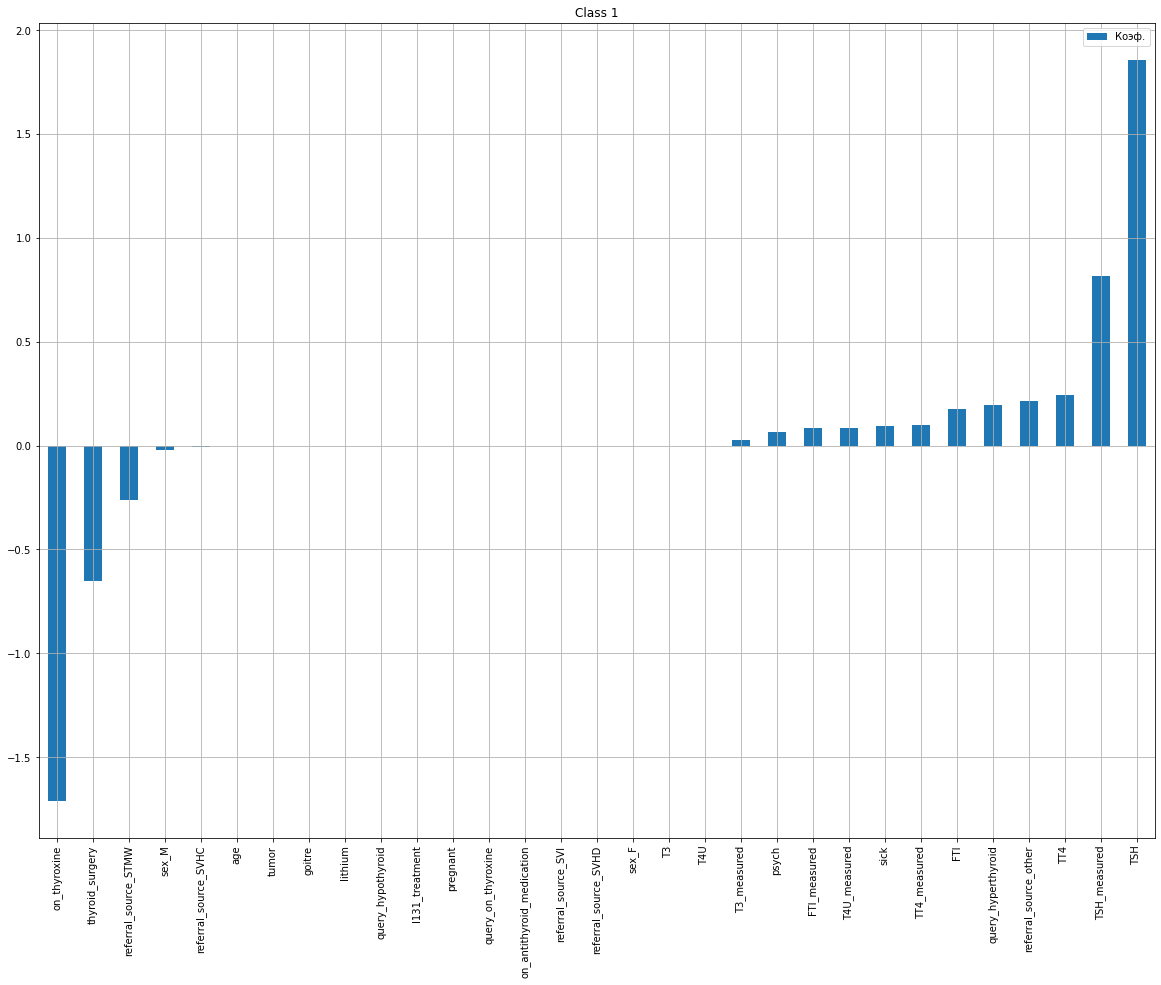

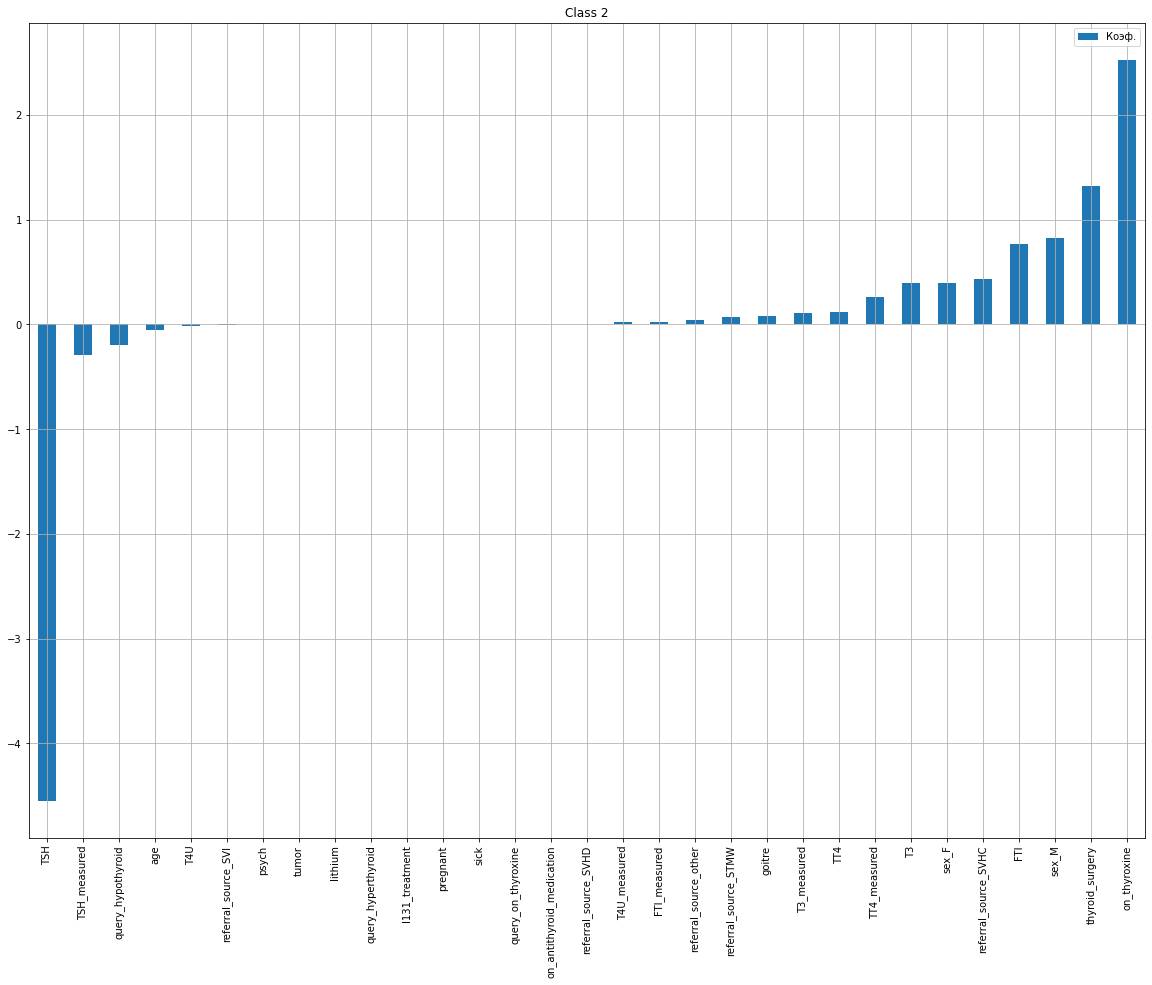

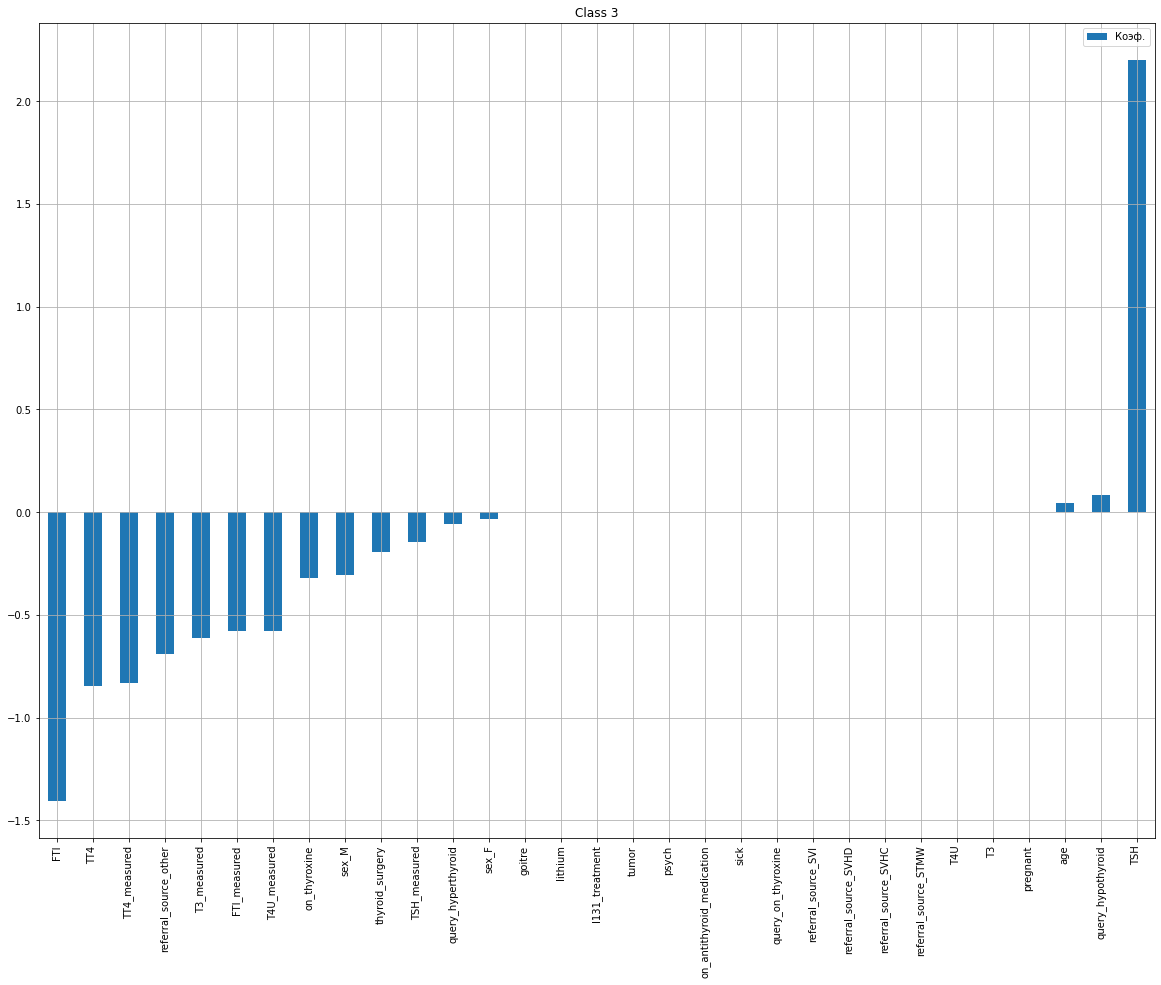

In [58]:
model = LogisticRegression(solver = 'saga' ,penalty='l1', random_state=SEED)
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])
logistic_pipeline.fit(X_train, y_train)
prob_preds = logistic_pipeline.predict_proba(X_valid)
print('logloss', log_loss(y_valid, prob_preds))
print('Полнота ', recall_score(y_valid, preds, average='macro'))
print('Точность ',precision_score(y_valid, preds, average='macro'))
print('F1 ', f1_score(y_valid, preds, average='macro'))
for i in range(3):
    coef = pd.DataFrame(logistic_pipeline[1].coef_[i], cols).sort_values(by=0)
    coef.columns = ['Коэф.']
    coef.plot.bar(grid=True, title='Сlass ' + str(i + 1), figsize=(20, 15))

Нелинейные изменения

Самым значим численным параметром, при регуляризации L1 , является T3 , добавил квадрат T3

In [59]:
X_train['T3^2'] = X_train['T3'] ** 2
X_valid['T3^2'] = X_valid['T3'] ** 2
X_test['T3^2'] = X_test['T3'] ** 2
cols.append('T3^2')
num_cols.append('T3^2')

logloss 0.15412292859978985
Полнота  0.7397023191415716
Точность  0.9376851978051377
F1  0.7826073476886993


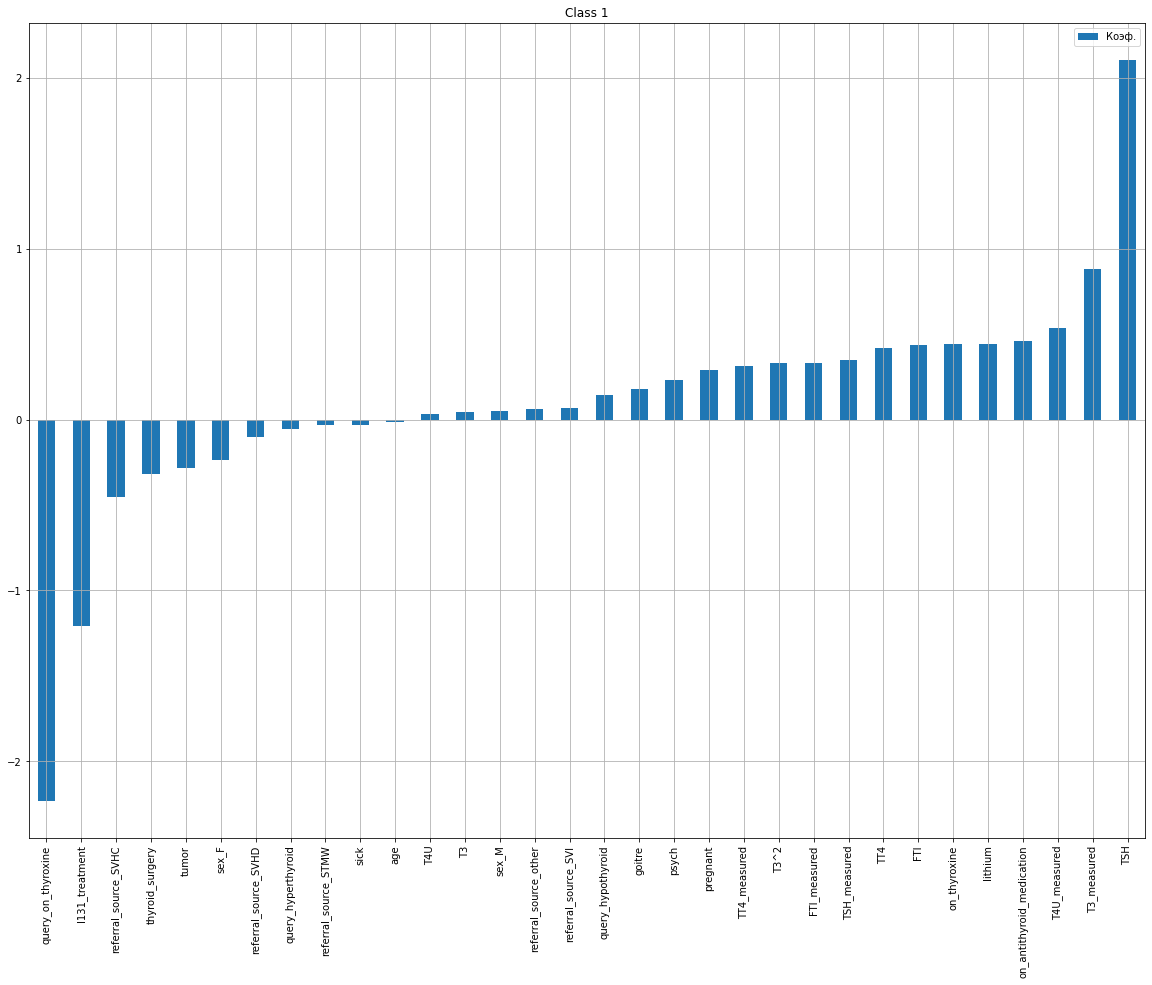

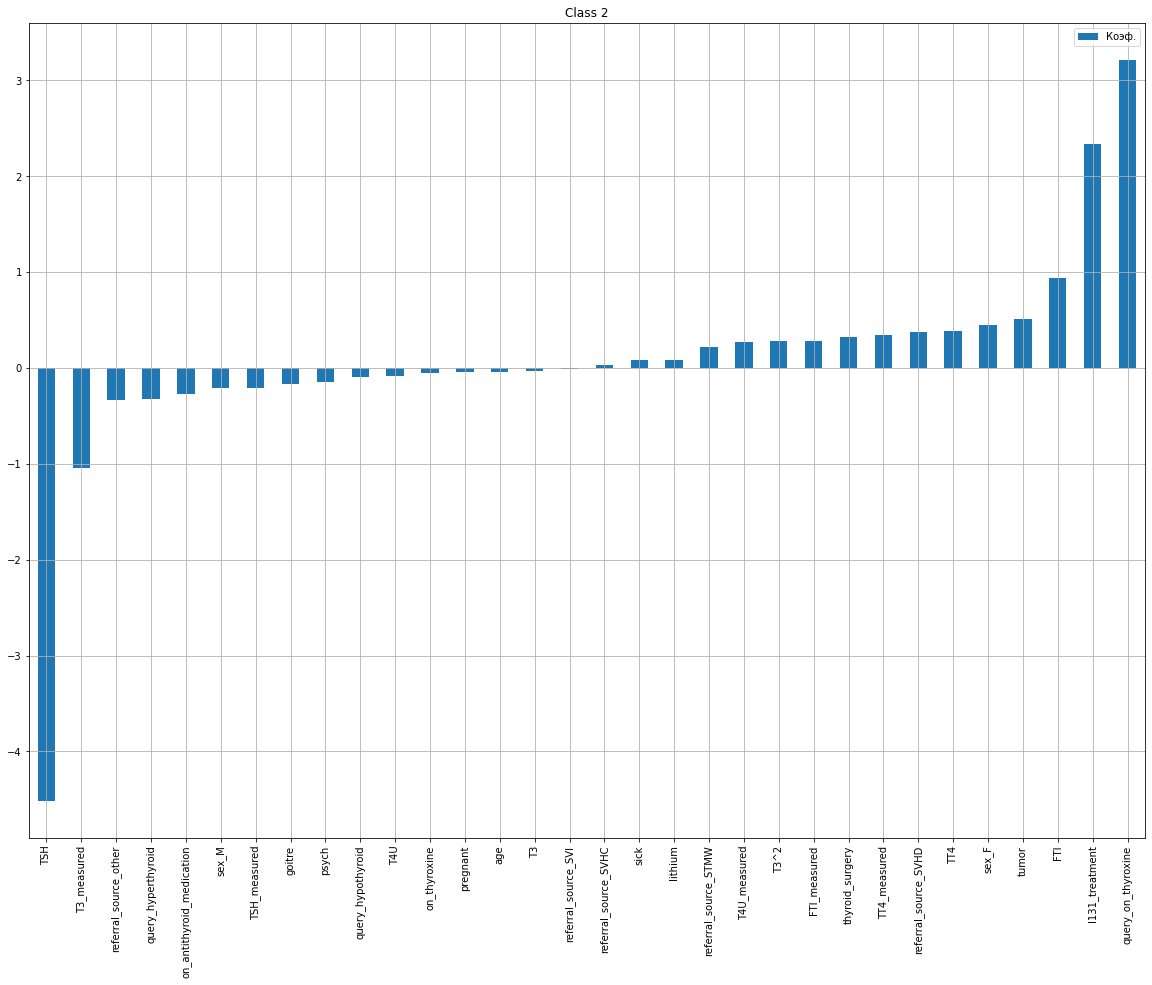

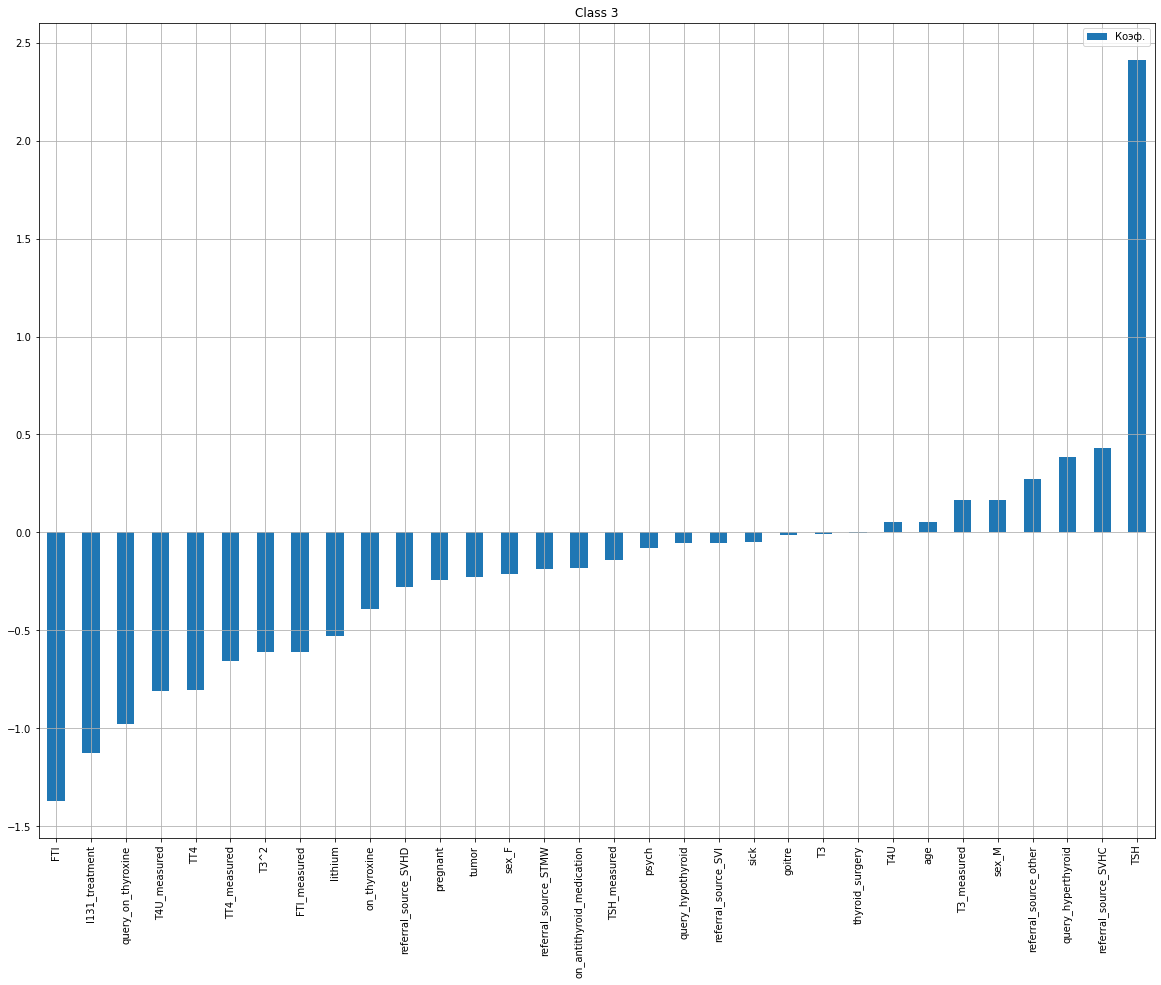

In [60]:
model = LogisticRegression(penalty='l2', random_state=SEED)
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])
logistic_pipeline.fit(X_train, y_train)
preds = logistic_pipeline.predict(X_valid)
prob_preds = logistic_pipeline.predict_proba(X_valid)
print('logloss', log_loss(y_valid, prob_preds))
print('Полнота ', recall_score(y_valid, preds, average='macro'))
print('Точность ',precision_score(y_valid, preds, average='macro'))
print('F1 ', f1_score(y_valid, preds, average='macro'))
for i in range(3):
    coef = pd.DataFrame(logistic_pipeline[1].coef_[i], cols).sort_values(by=0)
    coef.columns = ['Коэф.']
    coef.plot.bar(grid=True, title='Сlass ' + str(i + 1), figsize=(20, 15))

###  Elastic net

logloss 0.15773949082557912
Полнота  0.7304430598823123
Точность  0.9341760922599246
F1  0.7709493429705843


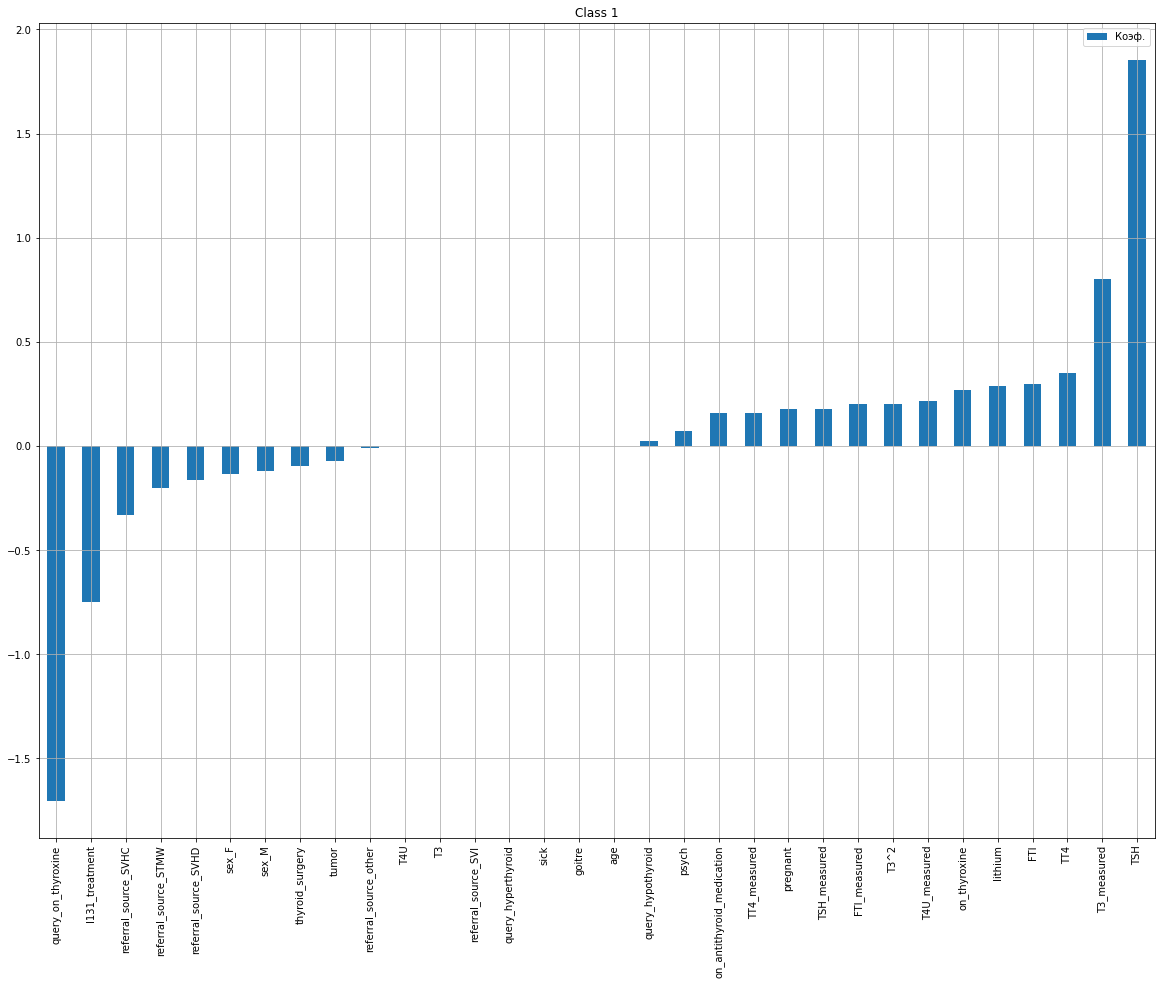

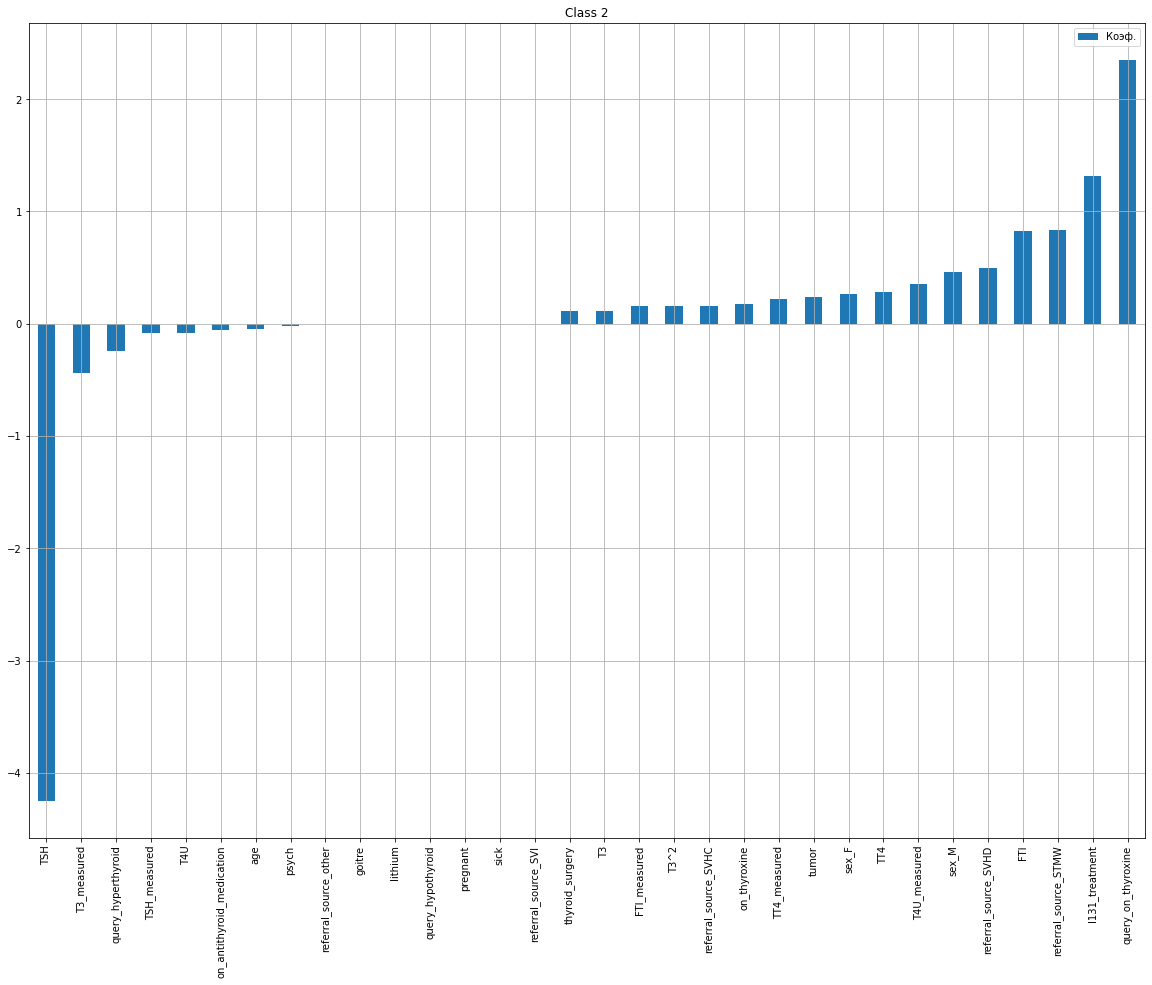

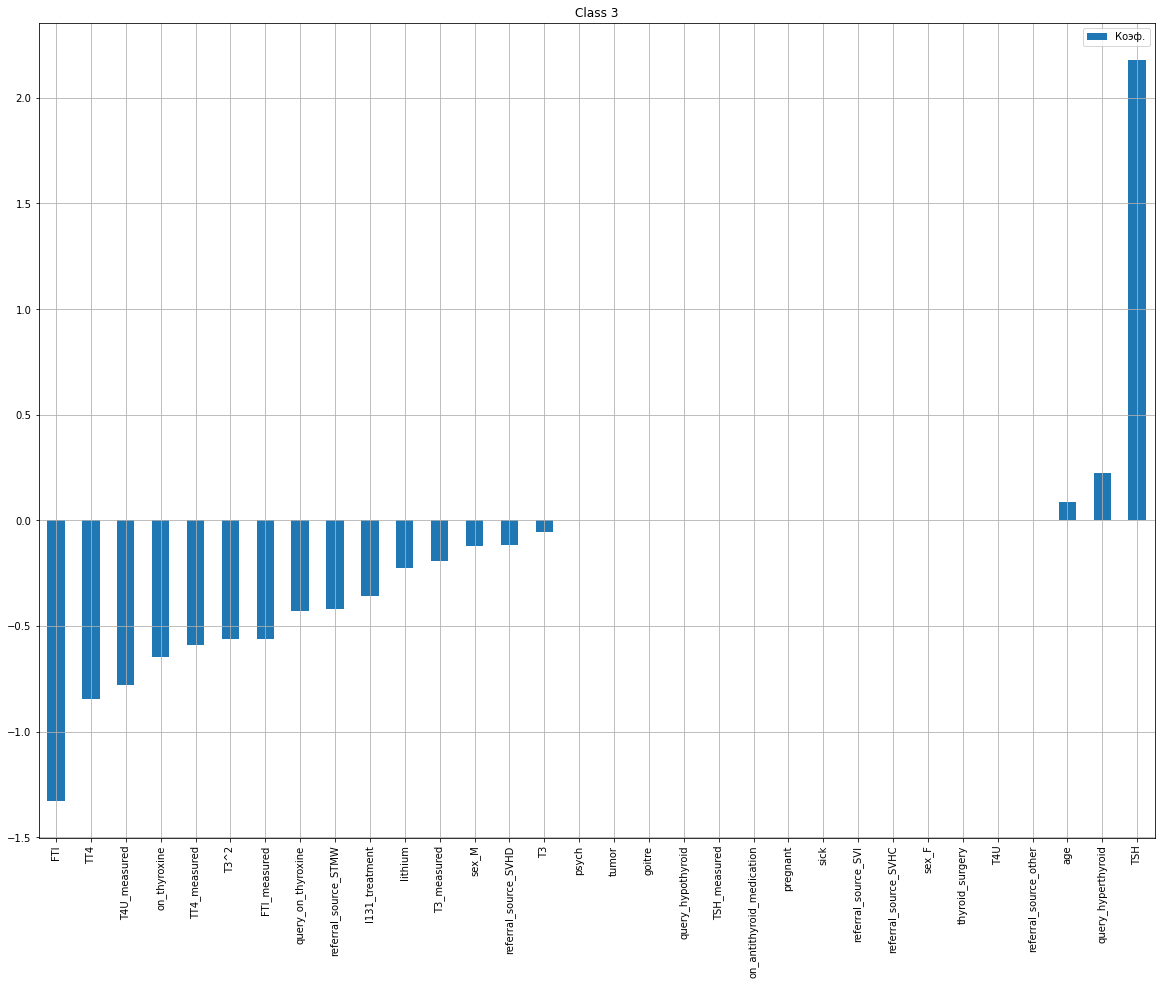

In [61]:
model = LogisticRegression(solver = 'saga' ,penalty='elasticnet', l1_ratio=0.5, random_state=SEED)
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])
logistic_pipeline.fit(X_train, y_train)
preds = logistic_pipeline.predict(X_valid)
prob_preds = logistic_pipeline.predict_proba(X_valid)
print('logloss', log_loss(y_valid, prob_preds))
print('Полнота ', recall_score(y_valid, preds, average='macro'))
print('Точность ',precision_score(y_valid, preds, average='macro'))
print('F1 ', f1_score(y_valid, preds, average='macro'))
for i in range(3):
    coef = pd.DataFrame(logistic_pipeline[1].coef_[i], cols).sort_values(by=0)
    coef.columns = ['Коэф.']
    coef.plot.bar(grid=True, title='Сlass ' + str(i + 1), figsize=(20, 15))

## Выводы
Так как в задаче речь идет о здоровье человека, в этом случае будет выгодным взять модель с регуляризацией <b>L2</b>, так как этот вариант имеет наибольшую полноту, то есть наилучшим образом определяет больных. 

## Подбор гиперпараметров для L2

In [62]:
cv = StratifiedKFold(5, random_state=SEED)
model = LogisticRegression(penalty='l2')
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

In [63]:
tuning_param = {'model__C': np.arange(0.1, 1, 0.1),
    'model__max_iter': range(50, 200, 10),
   }

In [64]:
clf = GridSearchCV(logistic_pipeline, cv=cv, scoring='recall_macro', param_grid=tuning_param)
clf.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=13, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'TSH',
                                                                          'T3',
                                                                          'TT4',
                           

In [65]:
clf.best_params_

{'model__C': 0.9, 'model__max_iter': 60}

In [66]:
preds = clf.predict_proba(X_test)
label_preds = np.argmax(preds, axis=1)

In [67]:
print(label_preds.shape)
y_test.shape

(928,)


(928,)

In [68]:
from sklearn.metrics import classification_report
print(classification_report(y_test, label_preds))

              precision    recall  f1-score   support

           0       0.82      0.38      0.51        48
           1       0.96      1.00      0.98       856
           2       0.85      0.71      0.77        24

    accuracy                           0.96       928
   macro avg       0.88      0.69      0.76       928
weighted avg       0.95      0.96      0.95       928



# KNN

In [201]:
?KNeighborsClassifier

In [69]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

model = KNeighborsClassifier(algorithm='kd_tree')
KNN_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

KNN_pipeline.fit(X_train, y_train)
preds=KNN_pipeline.predict(X_valid)
prob_preds = KNN_pipeline.predict_proba(X_valid)
print('logloss', log_loss(y_valid, prob_preds))
print('Полнота ', recall_score(y_valid, preds, average='macro'))
print('Точность ',precision_score(y_valid, preds, average='macro'))
print('F1 ', f1_score(y_valid, preds, average='macro'))


logloss 0.8872531338966566
Полнота  0.6450328833506404
Точность  0.791400685834872
F1  0.6770404271548437


In [70]:
model = KNeighborsClassifier(algorithm='brute')
KNN_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

KNN_pipeline.fit(X_train, y_train)
preds=KNN_pipeline.predict(X_valid)
prob_preds = KNN_pipeline.predict_proba(X_valid)
print('logloss', log_loss(y_valid, prob_preds))
print('Полнота ', recall_score(y_valid, preds, average='macro'))
print('Точность ',precision_score(y_valid, preds, average='macro'))
print('F1 ', f1_score(y_valid, preds, average='macro'))


logloss 0.8872531338966566
Полнота  0.6450328833506404
Точность  0.791400685834872
F1  0.6770404271548437


In [71]:
model = KNeighborsClassifier(algorithm='ball_tree')
KNN_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

KNN_pipeline.fit(X_train, y_train)
preds=KNN_pipeline.predict(X_valid)
prob_preds = KNN_pipeline.predict_proba(X_valid)
print('logloss', log_loss(y_valid, prob_preds))
print('Полнота ', recall_score(y_valid, preds, average='macro'))
print('Точность ',precision_score(y_valid, preds, average='macro'))
print('F1 ', f1_score(y_valid, preds, average='macro'))


logloss 0.8872531338966566
Полнота  0.6450328833506404
Точность  0.791400685834872
F1  0.6770404271548437


In [72]:
cv = StratifiedKFold(5, random_state=SEED)
model = KNeighborsClassifier()
KNN_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

In [74]:
tuning_param = {
    'model__algorithm' : ['auto', 'kd_tree', 'ball_tree', 'brute'],
    'model__leaf_size': range(20, 40) ,
    'model__n_neighbors': range(3, 10),
    'model__p': range(1, 3)
   }

In [75]:
clf = GridSearchCV(KNN_pipeline, cv=cv, scoring='recall_macro', param_grid=tuning_param)
clf.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=13, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'TSH',
                                                                          'T3',
                                                                          'TT4',
                           

In [76]:
clf.best_params_

{'model__algorithm': 'auto',
 'model__leaf_size': 20,
 'model__n_neighbors': 3,
 'model__p': 2}

In [77]:
preds = clf.predict(X_test)

In [80]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.41      0.15      0.22        48
           1       0.95      0.99      0.97       856
           2       0.85      0.71      0.77        24

    accuracy                           0.94       928
   macro avg       0.74      0.61      0.65       928
weighted avg       0.92      0.94      0.93       928

